In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from linares_plot import *
import os
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind
import scipy
from scikits.bootstrap import ci 
from scipy.stats import norm
import matplotlib.mlab as mlab


c_r1= '#e66101' #'#fdb863' # '#998ec3' #'#d8b365' #, '#8da0cb'
c_r3= '#5e3c99' #'#b2abd2' #'#f1a340' #'#5ab4ac' #'#fc8d62'
c_d0='grey'
c_d3 = '#91cf60'



#data_psychophysics_corrected
data = pd.read_csv('C:\\Users\\David\\Dropbox\\IDIBAPS\\my code\\Project 1 (master thesis)\\idibaps_psychophysics')
df=data.loc[(data['type']==1) | (data['type']==2)]

In [2]:
print(len(df))

def mod(target,report,radius_t, radius_r):
    #units given in degrees and cm
    y_t=np.array(radius_t*np.sin(np.radians(target)),dtype=np.float)
    x_t=np.array(radius_t*np.cos(np.radians(target)),dtype=np.float)
    y_r=np.array(radius_r*np.sin(np.radians(report)),dtype=np.float)
    x_r=np.array(radius_r*np.cos(np.radians(report)),dtype=np.float)
    m = np.sqrt((x_t - x_r)**2 + (y_t - y_r)**2)
    return m


modules = [round(mod(df.loc[i,'A_T'], df.loc[i,'A_R'], df.loc[i,'r_T'], df.loc[i,'r_R']),3) for i in df.index]
df['modules']=modules


from pandas import concat
frames=[]
for group_label in df.subject.unique():
    sub_group=df.groupby('subject').get_group(group_label)
    #CI
    #interval = sub_group.quantile([0.025, 0.975]).unstack(level=1)['A_err']
    #removed_out = sub_group.loc[(sub_group['A_err']>interval.iloc[0]) & (sub_group['A_err']<interval.iloc[1])] 
    #
    #Quartiles
    limit=sub_group['modules'].mean() + 2*sub_group['modules'].std()
    #print(round(limit,2))
    removed_out =sub_group.loc[sub_group['modules']<limit  ]
    
    
    frames.append(removed_out)
    
    #Print the result
    before_outliers=len(sub_group)
    after_outliers=len(removed_out)
    print( 'Outliers in ' + str(group_label) + ' = ' +str(before_outliers-after_outliers) + ', limit=' +str(round(limit,2))  + 'cm')
    


df = concat(frames)
print(len(df))

### Distribution A_Err in cw-ccw
# sns.distplot(df['A_err'], kde=False)
# plt.title('Distribution Angle error')
# plt.legend(frameon=False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['top'].set_visible(False)
# plt.gca().get_xaxis().tick_bottom()
# plt.gca().get_yaxis().tick_left()
# plt.xlabel('Angle error (Target-Response)')
# plt.show()

scipy.stats.normaltest(df['A_err'])

2403
Outliers in 1 = 2, limit=3.79cm
Outliers in 2 = 4, limit=2.92cm
Outliers in 3 = 5, limit=3.18cm
Outliers in 4 = 1, limit=2.81cm
Outliers in 5 = 9, limit=2.41cm
Outliers in 6 = 6, limit=5.03cm
Outliers in 7 = 6, limit=3.33cm
Outliers in 8 = 7, limit=2.93cm
Outliers in 9 = 7, limit=3.96cm
Outliers in 10 = 4, limit=4.12cm
Outliers in 11 = 6, limit=4.49cm
Outliers in 12 = 4, limit=3.21cm
Outliers in 13 = 7, limit=3.33cm
Outliers in 14 = 5, limit=3.59cm
Outliers in 15 = 4, limit=3.5cm
Outliers in 16 = 4, limit=4.16cm
Outliers in 17 = 8, limit=3.32cm
Outliers in 18 = 7, limit=4.54cm
2307


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


NormaltestResult(statistic=18.13955562885638, pvalue=0.0001150921076113315)

In [3]:
## Functions to use

def circ_dist(a1,a2):
    ## Returns the minimal distance in angles between to angles 
    op1=abs(a2-a1)
    angs=[a1,a2]
    op2=min(angs)+(360-max(angs))
    options=[op1,op2]
    return min(options)



def get_quadrant(angle): 
    #angle in degrees, return the quadrant which it belongs to
    if angle>=0 and angle<=90:
        Q=1
    elif angle>90 and angle<=180:
        Q=2
    elif angle>180 and angle<=270:
        Q=3
    elif angle>270 and angle<=360:
        Q=4
    
    return Q


def cw_ccw_detector(target, NT):
    #print [target, NT,get_quadrant(target),get_quadrant(NT) ]
    #it returns the relative position of the target respect the NT
    if abs(target-NT)<180:
        if target<NT: 
            o='cw'
        else: 
            o='ccw'
    else:
        if target<NT: 
            o='ccw'
        else: 
            o='cw'
    #Ecceptions
    if [get_quadrant(target),get_quadrant(NT) ] == [1,4] : o= 'ccw'
    if [get_quadrant(target),get_quadrant(NT) ] == [4,1] : o= 'cw'
    
    return o



In [4]:
#Add necessary column
orients=[]
for i in range(0, len(df)):
    orients.append(cw_ccw_detector(df['A_T'].iloc[i], df['A_NT'].iloc[i]))

    
df['cw_ccw']=orients
df['dist_T_NT']=abs(df['A_T']-df['A_NT'])

In [5]:
##### DISTANCE TO MEAN OF CW AND CCW as a measure
means_cw={}

for Subj in df.subject.unique():
    d_subj = df.groupby('subject').get_group(Subj)
    for ori in ['cw', 'ccw']:
        for distance in df.dist_T_NT.unique():
            for radius in df.r_T.unique():
                for delay in df.delay.unique():
                    mean_cw = round(d_subj.loc[ (d_subj['cw_ccw']==ori)  & (d_subj['r_T']==radius)
                                               & (d_subj['dist_T_NT']==distance) & (d_subj['delay']==delay) ,'A_err'].mean(), 3)
                    
                    means_cw[str(Subj)  + '_' + str(radius) + '_' +str(distance) +'_'+ str(delay) + '_' +ori] = mean_cw
                

        
cw_ccw_distance=[]

for i in df.index:
    or_ = df.loc[i, 'cw_ccw']
    if or_ == 'cw':
        or_cont = 'ccw'
    elif or_ =='ccw':
        or_cont = 'cw' 
    else:
        print('Error')
    idx =  str(df.loc[i, 'subject'])+ '_' + str(df.loc[i, 'r_T']) + '_' +str(df.loc[i, 'dist_T_NT']) +'_' +str(df.loc[i, 'delay']) +'_'  + or_cont
    #
    if or_ == 'ccw':
        cw_ccw_distance.append(df.loc[i, 'A_err'] - means_cw[idx] )  
    elif or_ =='cw':
        cw_ccw_distance.append( means_cw[idx] - df.loc[i, 'A_err'])  
    else:
        print('Error')
    


df['distance_A_err'] = np.array(cw_ccw_distance)/2
print(len(df))

#Remove null
df=df[~df['distance_A_err'].isnull()]
print(len(df))

2307
2291


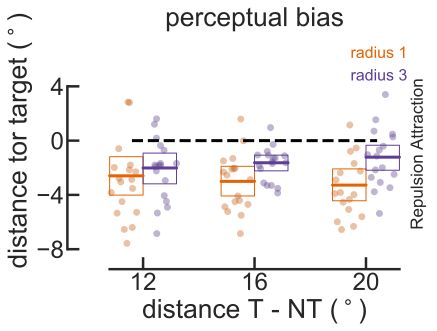

p_values:  12: 0.09205, 14: 0.00001, 20: 0.00000 
           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: distance_A_err
No. Observations: 1169    Method:             REML          
No. Groups:       18      Scale:              6.7009        
Min. group size:  16      Likelihood:         -2806.6805    
Max. group size:  98      Converged:          Yes           
Mean group size:  64.9                                      
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          0.388    1.452  0.267 0.789 -2.457  3.233
r_T               -0.275    0.127 -2.161 0.031 -0.524 -0.026
dist_T_NT         -0.329    0.086 -3.820 0.000 -0.497 -0.160
r_T:dist_T_NT      0.031    0.008  3.991 0.000  0.016  0.046
Group Var          2.519    0.349                           



In [ ]:
###Linares plot box

plt.figure()
linares_plot(x='dist_T_NT', y='distance_A_err', hue='r_T', order=[12,16,20], hue_order=[7.72,13.68],
             alpha=0.4, palette=[c_r1, c_r3], df=df.loc[df['delay']==0], point_size=7,  by_subj=True, subj_col='subject', 
             reps=1000)
plt.plot([-0.1,2.1], [0,0], 'k--');
plt.ylim(-8,4);
plt.title('perceptual bias')
plt.xlabel(r'distance T - NT ($^\circ$)');
plt.ylabel(r'distance tor target ($^\circ$)');
plt.yticks([-8, -4, 0, 4, 8]);
l = plt.legend(loc=1, frameon=False, prop={'size': 16})
l.get_texts()[0].set_text('radius 1');
l.get_texts()[0].set_color(c_r1);
l.get_texts()[1].set_text('radius 3');
l.get_texts()[1].set_color(c_r3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);
plt.text(2.4, 3.7, 'Attraction', fontsize=17, rotation='vertical');
plt.text(2.4, -1.9, 'Repulsion', fontsize=17, rotation='vertical');
plt.show()




### TTESTS

df_d0 = df.loc[df['delay']==0]

p_values=[]

for dist in [12, 16, 20]:
    a= df_d0[(df_d0['r_T'] == 7.72 ) & (df_d0['dist_T_NT'] == dist) ]['distance_A_err']
    b= df_d0[(df_d0['r_T'] == 13.68 ) & (df_d0['dist_T_NT'] == dist) ]['distance_A_err']
    p_values.append(ttest_ind(a,b)[1])


print(r'p_values:  12: %.5f, 14: %.5f, 20: %.5f ' %(p_values[0], p_values[1], p_values[2]))
#print(p_values)

#### MODEL
res_m = smf.mixedlm(formula='distance_A_err ~ r_T * dist_T_NT', data=df_d0, groups=df_d0['subject']).fit()
print(res_m.summary())




###Linares plot line
plt.figure()
linares_plot(x='dist_T_NT', y='distance_A_err', hue='r_T', order=[12,16,20], hue_order=[7.72,13.68],
             alpha=0.4, palette=[c_r1, c_r3], df=df.loc[df['delay']==0], point_size=7,  by_subj=True, subj_col='subject',
            plot_box='line', reps=1000)
plt.plot([-0.1,2.1], [0,0], 'k--');
plt.ylim(-8,4);
plt.title('perceptual bias')
plt.xlabel(r'distance T - NT ($^\circ$)');
plt.ylabel(r'distance tor target ($^\circ$)');
plt.yticks([-8, -4, 0, 4, 8]);
l = plt.legend(loc=3, frameon=False, prop={'size': 16})
l.get_texts()[0].set_text('radius 1');
l.get_texts()[0].set_color(c_r1);
l.get_texts()[1].set_text('radius 3');
l.get_texts()[1].set_color(c_r3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);
plt.text(2.4, 3.7, 'Attraction', fontsize=17, rotation='vertical');
plt.text(2.4, -1.9, 'Repulsion', fontsize=17, rotation='vertical');
plt.show()





In [ ]:
## Mixed model (subject as random intercept)
res_m = smf.mixedlm(formula='distance_A_err ~ r_T * dist_T_NT*delay', data=df, groups=df['subject']).fit()
print(res_m.summary())

In [ ]:
#Measure d3-d0

d0={}

for Subj in df.subject.unique():
    d_subj = df.groupby('subject').get_group(Subj)
    for ori in ['cw', 'ccw']:
        for distance in df.dist_T_NT.unique():
            for radius in df.r_T.unique():
                mean_d0 = round(d_subj.loc[ (d_subj['cw_ccw']==ori)  & (d_subj['r_T']==radius)
                                           & (d_subj['dist_T_NT']==distance) & (d_subj['delay']==0) ,'distance_A_err'].mean(), 3)

                d0[str(Subj)  + '_' + str(radius) + '_' +str(distance) + '_' +ori] = mean_d0



dist_A_err_d3_d0=[]

for i in df.index:
    idx =  str(df.loc[i, 'subject'])+ '_' + str(df.loc[i, 'r_T']) + '_' +str(df.loc[i, 'dist_T_NT']) +'_'  + df.loc[i, 'cw_ccw']
    #
    dist_A_err_d3_d0.append(df.loc[i, 'distance_A_err'] - d0[idx] )

    


df['dist_A_err_d3_d0'] = dist_A_err_d3_d0

In [ ]:

linares_plot(x='dist_T_NT', y='dist_A_err_d3_d0', hue='r_T', order=[12,16,20], hue_order=[7.72,13.68], 
             alpha=0.2, palette=[c_r1, c_r3], df=df.loc[df['delay']==3], point_size=7,  by_subj=True, subj_col='subject',
              plot_box=True, reps=1000)

plt.plot([-0.3, 2.3], [0,0], 'k--', linewidth=2.5);
plt.title('memory bias')
plt.xlabel(r'distance T - NT ($^\circ$)');
plt.ylabel(r'distance tor target ($^\circ$)');
plt.yticks([ -5, -2.5,  0, 2.5, 5]);
plt.ylim(-3,3.3);
l = plt.legend(loc='best', frameon=False, prop={'size': 16})
l.get_texts()[0].set_text('radius 1');
l.get_texts()[0].set_color(c_r1);
l.get_texts()[1].set_text('radius 3');
l.get_texts()[1].set_color(c_r3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);
plt.text(0.65, 2.5, 'Attraction', fontsize=17);
plt.text(0.65, -2.5, 'Repulsion', fontsize=17);
plt.show()



## pvalues
p_values=[]
for dist in [12, 16, 20]:
    a= df[(df['r_T'] == 7.72 ) & (df['dist_T_NT'] == dist) ]['dist_A_err_d3_d0']
    b= df[(df['r_T'] == 13.68 ) & (df['dist_T_NT'] == dist) ]['dist_A_err_d3_d0']
    p_values.append(ttest_ind(a,b)[1])

#print(p_values)
print(r'p_values:  12: %.5f, 14: %.5f, 20: %.5f ' %(p_values[0], p_values[1], p_values[2]))


#### MODEL
res_m = smf.mixedlm(formula='dist_A_err_d3_d0 ~ r_T * dist_T_NT', data=df.loc[df['delay']==3], groups=df.loc[df['delay']==3, 'subject']).fit()
print(res_m.summary())



###linares plot line
linares_plot(x='dist_T_NT', y='dist_A_err_d3_d0', hue='r_T', order=[12,16,20], hue_order=[7.72,13.68], 
             alpha=0.4, palette=[c_r1, c_r3], df=df.loc[df['delay']==3], point_size=5,  
             by_subj=True, subj_col='subject',
              plot_box='line', LW=3, MS=10, reps=1000)

plt.plot([-0.3, 2.3], [0,0], 'k--', linewidth=2.5);
plt.title('memory bias')
plt.xlabel(r'distance T - NT ($^\circ$)');
plt.ylabel(r'distance to target ($^\circ$)');
plt.yticks([ -4, -2,  0, 2, 4]);
plt.ylim(-4,4);
l = plt.legend(loc=3, frameon=False, prop={'size': 16})
l.get_texts()[0].set_text('radius 1');
l.get_texts()[0].set_color(c_r1);
l.get_texts()[1].set_text('radius 3');
l.get_texts()[1].set_color(c_r3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);
plt.text(2.4, 2.7, 'Attraction', fontsize=17, rotation='vertical');
plt.text(2.4, -0.7, 'Repulsion', fontsize=17, rotation='vertical');
plt.show()




In [ ]:
f = plt.figure(figsize=(15,6))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)


plt.subplot(121)
sns.distplot(df.loc[(df['delay']==0) & (df['dist_T_NT']==12) & (df['r_T']==7.72), 'distance_A_err'] , bins=np.linspace(-10,10,25), 
              fit=norm, kde=False, fit_kws={"color":c_r1, 'linewidth':2}, label='radius 1', color=c_r1, ax=ax)
sns.distplot(df.loc[(df['delay']==0) & (df['dist_T_NT']==12) & (df['r_T']==13.68), 'distance_A_err'] , bins=np.linspace(-10,10,25),
             fit=norm, kde=False, fit_kws={"color":c_r3, 'linewidth':2}, label='radius 3',  color=c_r3,ax=ax)
plt.plot([0, 0], [0,0.17], 'k--', linewidth=2.5, label='target');
plt.xlim(-18,18)
plt.ylim(0.02)
plt.yticks([0.1,0.2])
#plt.plot([12, 12], [0,0.17], color='grey', linestyle='-', linewidth=2.5, label='NT');
plt.plot((12,10), "^", color='grey', markersize=10, label='NT');

#l = plt.legend(loc='best', frameon=False, prop={'size': 16})
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.xlabel(r'distance to target ($^\circ$)')
plt.ylabel('frequency')
plt.text(5.2, 0.06, 'attraction', fontsize=22);
plt.text(-16, 0.06, 'repulsion', fontsize=22);
#plt.title(r'12$\circ$: Delay0')
plt.title('perceptual bias')
plt.annotate('', xy=(-16, 0.05),  xytext=(-9, 0.05),  arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='bottom');

plt.annotate('', xy=(12, 0.05), xytext=(5, 0.05), arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='bottom');


pts = [(11, 0), (12, 0.04), (13, 0)]
triangle = plt.Polygon(pts, color='grey', fill=True, edgecolor='grey')
ax.add_patch(triangle)


plt.subplot(122)
sns.distplot(df.loc[(df['delay']==3) & (df['dist_T_NT']==12) & (df['r_T']==7.72), 'dist_A_err_d3_d0'] , bins=np.linspace(-10,10,25),
              fit=norm, kde=False, fit_kws={"color":c_r1, 'linewidth':2}, label='radius 1', color=c_r1, ax=ax2)
sns.distplot(df.loc[(df['delay']==3) & (df['dist_T_NT']==12) & (df['r_T']==13.68), 'dist_A_err_d3_d0'] , bins=np.linspace(-10,10,25),
             fit=norm, kde=False, fit_kws={"color":c_r3, 'linewidth':2}, label='radius 3',  color=c_r3, ax=ax2)
plt.plot([0, 0], [0,0.17], 'k--', linewidth=2.5, label='target');
plt.xlim(-18,18)
plt.ylim(0.02)
plt.yticks([0.1,0.2])

##triangulo locura
plt.plot((12,10), "^", color='grey', markersize=10, label='NT');



l = plt.legend(loc='best', frameon=False, prop={'size': 16})
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.xlabel(r'distance to target ($^\circ$)')
plt.ylabel('')
#plt.text(5.2, 0.06, 'attraction', fontsize=22);
#plt.text(-16, 0.06, 'repulsion', fontsize=22);
#plt.title(r'12$\circ$: Delay3 - Delay0')
plt.yticks([0.1,0.2], ['', ''])

plt.title('memory bias')
# plt.annotate('', xy=(-16, 0.05),  xytext=(-9, 0.05),  arrowprops=dict(facecolor='black', shrink=0.05),
#             horizontalalignment='left', verticalalignment='bottom');

# plt.annotate('', xy=(12, 0.05), xytext=(5, 0.05), arrowprops=dict(facecolor='black', shrink=0.05),
#            horizontalalignment='left', verticalalignment='bottom');




pts = [(11, 0), (12, 0.04), (13, 0)]
triangle = plt.Polygon(pts, color='grey', fill=True, edgecolor='grey')
ax2.add_patch(triangle)


plt.tight_layout()

In [ ]:
df_cont=data.loc[data['type']==0]
print(len(df_cont))

def mod(target,report,radius_t, radius_r):
    #units given in degrees and cm
    y_t=np.array(radius_t*np.sin(np.radians(target)),dtype=np.float)
    x_t=np.array(radius_t*np.cos(np.radians(target)),dtype=np.float)
    y_r=np.array(radius_r*np.sin(np.radians(report)),dtype=np.float)
    x_r=np.array(radius_r*np.cos(np.radians(report)),dtype=np.float)
    m = np.sqrt((x_t - x_r)**2 + (y_t - y_r)**2)
    return m


modules = [round(mod(df_cont.loc[i,'A_T'], df_cont.loc[i,'A_R'], df_cont.loc[i,'r_T'], df_cont.loc[i,'r_R']),3) for i in df_cont.index]
df_cont['modules']=modules


from pandas import concat
frames=[]
for group_label in df_cont.subject.unique():
    sub_group=df_cont.groupby('subject').get_group(group_label)
    #CI
    #interval = sub_group.quantile([0.025, 0.975]).unstack(level=1)['A_err']
    #removed_out = sub_group.loc[(sub_group['A_err']>interval.iloc[0]) & (sub_group['A_err']<interval.iloc[1])] 
    #
    #Quartiles
    limit=sub_group['modules'].mean() + 2*sub_group['modules'].std()
    #print(round(limit,2))
    removed_out =sub_group.loc[sub_group['modules']<limit  ]
    
    
    frames.append(removed_out)
    
    #Print the result
    before_outliers=len(sub_group)
    after_outliers=len(removed_out)
    print( 'Outliers in ' + str(group_label) + ' = ' +str(before_outliers-after_outliers) + ', limit=' +str(round(limit,2)) )
    


df_cont = concat(frames)
print(len(df_cont))

df_cont['abs_err']=abs(df_cont['A_err'].copy())

### Distribution A_Err in cw-ccw
# sns.distplot(df_cont['A_err'], kde=False)
# plt.title('Distribution Angle error')
# plt.legend(frameon=False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['top'].set_visible(False)
# plt.gca().get_xaxis().tick_bottom()
# plt.gca().get_yaxis().tick_left()
# plt.xlabel('Angle error (Target-Response)')
# plt.show()

In [ ]:


linares_plot(x='r_T', y='abs_err', hue='delay', hue_order=[0,3], order=[7.72,10.7,13.68], df=df_cont,palette=[c_d0, c_d3], 
            alpha=0.2, point_size=7,  by_subj=True, subj_col='subject', reps=1000)
plt.legend(frameon=False)
plt.title('error in eccentricity')
plt.xlabel('')
plt.xticks([0,1,2], ['radius 1', 'radius 2', 'radius 3'])
plt.ylabel(r'absolute error ($^\circ$)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.ylim(1, 8)
l = plt.legend(loc='best', frameon=False, prop={'size': 16})
l.get_texts()[0].set_text('delay 0')
l.get_texts()[1].set_text('delay 3')
l.get_texts()[0].set_color(c_d0);
l.get_texts()[1].set_color(c_d3);
plt.show()


linares_plot(x='r_T', y='abs_err', hue='delay', hue_order=[0,3], order=[7.72,10.7,13.68], df=df_cont,palette=[c_d0, c_d3], 
            alpha=0.2, point_size=7,  by_subj=True, subj_col='subject', plot_box='line', reps=1000)
plt.legend(frameon=False)
plt.title('error in eccentricity')
plt.xlabel('')
plt.xticks([0,1,2], ['radius 1', 'radius 2', 'radius 3'])
plt.ylabel(r'abs error ($^\circ$)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.ylim(1, 8)
l = plt.legend(loc='best', frameon=False, prop={'size': 16})
l.get_texts()[0].set_text('delay 0')
l.get_texts()[1].set_text('delay 3')
l.get_texts()[0].set_color(c_d0);
l.get_texts()[1].set_color(c_d3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);
plt.show()


### Model
res_m = smf.mixedlm(formula='abs_err ~ r_T*delay ', data=df_cont, groups=df_cont['subject']).fit()
print(res_m.summary())
             
             

In [ ]:
### Figure paper
f = plt.figure(figsize=(20,6))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)


plt.subplot(121)

# read data from a text file. One number per line
datos_d0_r1 = df_cont.loc[ (df_cont['r_T']==7.72) & (df_cont['delay']==0)   , 'A_err']
mu_r1, sigma_r1 = norm.fit(datos_d0_r1)
datos_d0_r3 = df_cont.loc[ (df_cont['r_T']==13.68) & (df_cont['delay']==0)   , 'A_err']
mu_r3, sigma_r3 = norm.fit(datos_d0_r3)

sns.distplot(datos_d0_r1, color= c_r1, fit=norm, kde=False, fit_kws={"color":c_r1, 'linewidth':5}, ax=ax, hist_kws={'alpha':0.3})
sns.distplot(datos_d0_r3, color=c_r3, fit=norm, kde=False, fit_kws={"color":c_r3, 'linewidth':5}, ax=ax, hist_kws={'alpha':0.3})

#plot
plt.xlabel(r'angle error ($^\circ$)')
plt.ylabel('frequency')
#plt.title(r'$\mathrm{Delay=0:}\ \sigma_{r1}=%.3f,\ \sigma_{r3}=%.3f$' %(sigma_r1, sigma_r3))
plt.title('perceptual error distribution',  fontsize=25, pad=10)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
adjust_spines(plt.gca(), ['left', 'bottom'])



plt.yticks([0, 0.05,0.1])
plt.xticks([-25, 0, 25])
plt.legend(frameon=False)
plt.ylim(0,0.1)
plt.xlim(-25,25)


plt.subplot(122)

# read data from a text file. One number per line
datos_d3_r1 = df_cont.loc[ (df_cont['r_T']==7.72) & (df_cont['delay']==3)   , 'A_err']
mu_r1, sigma_r1 = norm.fit(datos_d3_r1)
datos_d3_r3 = df_cont.loc[ (df_cont['r_T']==13.68) & (df_cont['delay']==3)   , 'A_err']
mu_r3, sigma_r3 = norm.fit(datos_d3_r3)

sns.distplot(datos_d3_r1, color= c_r1, fit=norm, kde=False, label='radius 1', fit_kws={"color":c_r1, 'linewidth':5}, ax=ax2, hist_kws={'alpha':0.3})
sns.distplot(datos_d3_r3, color=c_r3, fit=norm, kde=False, label='radius 3', fit_kws={"color":c_r3, 'linewidth':5},  ax=ax2, hist_kws={'alpha':0.3})

#plot
plt.xlabel(r'angle error ($^\circ$)')
plt.ylabel('')
#plt.title(r'$\mathrm{Delay=3:}\ \sigma_{r1}=%.3f,\ \sigma_{r3}=%.3f$' %(sigma_r1, sigma_r3))
plt.title('memory error distribution', fontsize=25, pad=10)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.yticks([0,0.05,0.1], ['', ''])
plt.xticks([-25, 0, 25])


plt.ylim(0,0.1)
plt.xlim(-25,25)

adjust_spines(plt.gca(), ['left', 'bottom'])


l = plt.legend(loc=1, frameon=False, prop={'size': 23})
l.get_texts()[0].set_text('radius 1');
l.get_texts()[0].set_color(c_r1);
l.get_texts()[1].set_text('radius 3');
l.get_texts()[1].set_color(c_r3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);


# Modeling

In [ ]:
df_mm = pd.read_excel('C:\\Users\\David\\Documents\\GitHub\\interference_topography\\simulations\\model\\please.xlsx')
df_mm=df_mm.loc[df_mm['success']==True]
df_b1 = df_mm[['b1', 'decod_f', 'kappas_E', 'kappas_I', 'separation', 'success']]
df_b1.columns=['bias', 'decod_f', 'kappas_E', 'kappas_I', 'separation', 'success']
df_b2 =df_mm[['b2','decod_f', 'kappas_E', 'kappas_I', 'separation', 'success']]
df_b2.columns=['bias', 'decod_f', 'kappas_E', 'kappas_I', 'separation', 'success']

In [ ]:
df_c = pd.read_excel('C:\\Users\\David\\Documents\\GitHub\\interference_topography\\simulations\\model\\please_close.xlsx')
df_c=df_c.loc[df_c['success']==True]
df_b3 = df_c[['b1', 'decod_f', 'kappas_E', 'kappas_I', 'separation', 'success']]
df_b3.columns=['bias', 'decod_f', 'kappas_E', 'kappas_I', 'separation', 'success']
df_b4 =df_c[['b2','decod_f', 'kappas_E', 'kappas_I', 'separation', 'success']]
df_b4.columns=['bias', 'decod_f', 'kappas_E', 'kappas_I', 'separation', 'success']

In [ ]:
df_model=pd.concat([df_b1, df_b2, df_b3, df_b4])


In [ ]:
plt.figure(figsize=(8,6))
g = sns.lineplot( x="separation", y="bias", hue='kappas_E', ci=95 , palette=[c_r3, c_r1], data=df_model) 
plt.plot([0, max(df_model['separation'])], [0,0], 'k--') 
plt.title('model: memory bias', fontsize=25) #condition title
plt.gca().spines['right'].set_visible(False) #no right axis
plt.gca().spines['top'].set_visible(False) #no  top axis
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
l = plt.legend(loc=4, frameon=False, prop={'size': 16})
l.get_texts()[0].set_text('');
l.get_texts()[1].set_text('radius 1: kappa=300');
l.get_texts()[1].set_color(c_r1);
l.get_texts()[2].set_text('radius 3: kappa=225');
l.get_texts()[2].set_color(c_r3);
l.legendHandles[1].set_visible(False);
l.legendHandles[2].set_visible(False);
plt.text(90, 10, 'Attraction', fontsize=17, rotation='vertical');
plt.text(90, -5, 'Repulsion', fontsize=17, rotation='vertical');
plt.xlabel(r'distance T - NT ($^\circ$)');
plt.ylabel(r'distance to target ($^\circ$)');
plt.show(block=False)

In [ ]:
plt.figure(figsize=(8,6))
g = sns.lineplot( x="separation", y="bias", hue='kappas_E', ci=95 , palette=[c_r3, c_r1], data=df_model) 
plt.plot([0, max(df_model['separation'])], [0,0], 'k--') 
plt.title('model: memory bias', fontsize=25) #condition title
plt.gca().spines['right'].set_visible(False) #no right axis
plt.gca().spines['top'].set_visible(False) #no  top axis
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
# plt.legend(title='kappaE', loc='upper right', labels=[str(i) for i in [225, 300]], frameon=False )
l = plt.legend(loc=3, frameon=False, prop={'size': 16})
l.get_texts()[0].set_text('');
l.get_texts()[1].set_text('radius 1: k=300');
l.get_texts()[1].set_color(c_r1);
l.get_texts()[2].set_text('radius 3: k=225');
l.get_texts()[2].set_color(c_r3);
l.legendHandles[1].set_visible(False);
l.legendHandles[2].set_visible(False);
plt.xlim(12, 35)
plt.text(35, 9, 'Attraction', fontsize=17, rotation='vertical');
plt.text(35, -5, 'Repulsion', fontsize=17, rotation='vertical');
plt.xlabel(r'distance T - NT ($^\circ$)');
plt.ylabel(r'distance to target ($^\circ$)');
plt.show(block=False)

In [ ]:
values_225 = df_model.loc[(df_model['separation']==22) & (df_model['kappas_E']==225) , 'bias']
values_300 =  df_model.loc[(df_model['separation']==22) & (df_model['kappas_E']==300) , 'bias']
#values_225 = values_225*12/22
#values_300 = values_300*12/22


f = plt.figure(figsize=(15,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

plt.plot([0, 0], [0,0.15], 'k--', linewidth=2.5, label='target');
plt.plot((700), "^", color='grey', markersize=10, label='NT');

sns.distplot(values_225, color=c_r3, bins=np.linspace(-50,50,100), kde=False, fit=norm, 
              label='radius 3', fit_kws={"color":c_r3, 'linewidth':0}, ax=ax2)
sns.distplot(values_300,  color=c_r1, bins=np.linspace(-50,50,100), kde=False, fit=norm, 
             label='radius 1', fit_kws={"color":c_r1, 'linewidth':0}, ax=ax2)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.xlabel(r'distance to target ($^\circ$)')
plt.ylabel('frequency')
#plt.text(8, 60, 'attraction', fontsize=22);
#plt.text(-10, 60, 'repulsion', fontsize=22);
#plt.title(r'12$\circ$: Delay3 - Delay0')
plt.yticks([0.1,0.2, 0.3])
plt.xticks([-30, -15, 0, 15, 30])
plt.xlim(-33, 33)
plt.ylim(0,0.2)
l = plt.legend(loc=1, frameon=False, prop={'size': 16})
l.get_texts()[2].set_text('radius 1: k=300');
l.get_texts()[2].set_color(c_r1);
l.get_texts()[3].set_text('radius 3: k=225');
l.get_texts()[3].set_color(c_r3);
l.legendHandles[2].set_color(c_r1);
l.legendHandles[3].set_color(c_r3);


pts = [(21, 0.), (22, 0.02), (23, 0.)]
triangle = plt.Polygon(pts, color='grey', fill=True, edgecolor='grey')
ax2.add_patch(triangle)

plt.title('model: memory bias')

f.delaxes(ax)


plt.show()

In [ ]:
df_1_a1 = pd.read_excel('C:\\Users\\David\\Documents\\GitHub\\interference_topography\\simulations\\model\\please_11.xlsx')
df_1_a2 = pd.read_excel('C:\\Users\\David\\Documents\\GitHub\\interference_topography\\simulations\\model\\please_12.xlsx')

df_1=pd.concat([df_1_a1, df_1_a2])
df_1 = df_1.loc[df_1['success']==True]
df_1 = df_1[abs(df_1.b2)<1.5*np.std(df_1.b2)]

df_1['abs_bias']=abs(df_1['b2'])

In [ ]:

f = plt.figure(figsize=(12,6))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

plt.subplot(121)

sns.distplot(df_1.loc[df_1['kappas_E']==300, 'b2'], color=c_r1,  bins=np.linspace(-30,30,60),
             label='radius 1', kde=False, fit=norm,  fit_kws={"color":c_r1, 'linewidth':5},
            hist_kws={'alpha':0.3}, ax=ax)

sns.distplot(df_1.loc[df_1['kappas_E']==225, 'b2'], color=c_r3,  bins=np.linspace(-30,30,60),
             label='radius 3', kde=False, fit=norm,  fit_kws={"color":c_r3, 'linewidth':5},
            hist_kws={'alpha':0.3}, ax=ax)



plt.xlabel(r'angle error ($^\circ$)')
plt.ylabel('')
plt.title('memory angle error')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.yticks([0, 0.06,  0.12], [0, 0.06, 0.12])
plt.xticks([-15, 0, 15])
plt.ylim(0,0.12)
plt.xlim(-25,25)
plt.ylabel('frequency')

l = plt.legend(loc=1, frameon=False, prop={'size': 18})
l.get_texts()[0].set_text('radius 1: k=300');
l.get_texts()[0].set_color(c_r1);
l.get_texts()[1].set_text('radius 3: k=225');
l.get_texts()[1].set_color(c_r3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);

f.delaxes(ax2)

In [ ]:
res_m = smf.ols(formula='abs_bias ~ kappas_E', data=df_1).fit()
print(res_m.summary())

In [ ]:
df_fg = pd.read_excel('C:\\Users\\David\\Documents\\GitHub\\interference_topography\\simulations\\model\\please_fit_gauss.xlsx')
df_fg=df_fg.loc[df_fg['success']==True]
df_fg = df_fg[abs(df_fg.gaussian_std)<1.5*np.std(df_fg.gaussian_std)]
df_fg = df_fg[df_fg.gaussian_std>0]

In [ ]:
plt.figure(figsize=(8,5))

c_tuning= '#e9a3c9'
c_error = '#a1d76a'

ax = sns.lineplot( x="kappas_E", y="abs_bias", ci=None, data=df_1, markers=True,  
                 linewidth=10, marker="o", markersize=25, color=c_error) 
plt.ylim(2.85, 3.75)
plt.yticks([2.85, 3.15, 3.45, 3.75])
plt.ylabel(r'abs error ($^\circ$)')
plt.gca().spines['top'].set_visible(False)
plt.tick_params(direction='in')
plt.xlabel('')
plt.xlim(200, 335)
plt.gca().invert_xaxis()
plt.xlabel('increasing connectivity width (1/k)', fontsize=24)
ax.yaxis.label.set_color(c_error)

ax2 = ax.twinx()
ax = sns.lineplot( x="kappas_E", y="gaussian_std", ci=None, data=df_fg, markers=True,  
                 linewidth=10, marker="o", markersize=25, color=c_tuning, ax=ax2) 

plt.ylim(0.1, 0.2)
plt.gca().spines['top'].set_visible(False)
plt.yticks([0.1, 0.15, 0.2])
plt.ylabel('tunning (std)')
plt.tick_params(direction='in')
plt.xlabel('increasing connectivity width (1/k)', fontsize=24)
plt.xticks([305, 220], ['radius 1','radius 3'], rotation=45)
ax.yaxis.label.set_color(c_tuning)


plt.title('model: error & tuning')
plt.tight_layout()
plt.show()

## Monkeys

In [ ]:
df_m = pd.read_excel('C:\\Users\\David\\Documents\\GitHub\\interference_topography\\figures\\df_stds_monkeys.xlsx')
df_m['tuning_std_deg'] = df_m['tuning_std']*180/np.pi
c_tuning= '#e9a3c9'
g =sns.factorplot( x="radius", y="tuning_std_deg", data=df_m, color=c_tuning, ci=68, size=5, aspect=1.5);
plt.setp(g.ax.lines, linewidth=7)

plt.xlabel('')
plt.ylabel('std')
plt.title('Tuning curve')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.xticks([0,1,2], ['radius 1', 'radius 2', 'radius 3'])
plt.legend(frameon=False)
#plt.ylim(1.65, 2.2);
#plt.yticks([ 1.8, 2, 2.2]);
plt.show()


model = smf.ols(formula="tuning_std_deg ~  radius", data=df_m).fit()
print(model.summary())




In [ ]:
df_firings = pd.read_excel('C:\\Users\\David\\Documents\\GitHub\\interference_topography\\figures\\df_norm_firings.xlsx')

c_tuning= '#e9a3c9'

c_r1= '#e66101' #'#fdb863' # '#998ec3' #'#d8b365' #, '#8da0cb'
c_r3= '#5e3c99' #'#b2abd2' #'#f1a340' #'#5ab4ac' #'#fc8d62

sns.factorplot( x="angle", y="firing", data=df_firings, hue='radius', 
               palette=[c_r1, c_r3], ci=68, size=6, aspect=1.5, legend=False);

plt.xlabel(r'angle ($\circ$)');
plt.ylabel('firing rate (zscore)')
plt.title('Tuning curves')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.xticks([ 0, 2, 4, 6, 8], [-180, -90, 0, 90, 180]);

l = plt.legend(loc=1, frameon=False, prop={'size': 25});
l.get_texts()[0].set_text('radius 1');
l.get_texts()[0].set_color(c_r1);
l.get_texts()[1].set_text('radius 3');
l.get_texts()[1].set_color(c_r3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);

plt.ylim(-0.8, 0.8);
plt.yticks([ -0.8, -0.4, 0, 0.4, 0.8]);


## Model currents

In [ ]:
current_225 = np.loadtxt('current_225.txt')
current_300 = np.loadtxt('current_300.txt')
sep_deg=23
N=512
sep_neurons = sep_deg*len(current_225)/360
ref=np.zeros(N)
att_color = '#e9a3c9'
rep_color= '#a1d76a'

In [ ]:
f = plt.figure(figsize=(13,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

plt.subplot(121)

static = current_300
displaced= np.roll(current_300, int(sep_neurons))
x=np.linspace(0,N-1,N)
plt.plot(static, color=c_r1, linewidth=2, alpha=0.8)
plt.plot([np.where(static == max(static))[0][0], np.where(static == max(static))[0][0]],[-1.5,7], 'k--', linewidth=1)
plt.plot(displaced, color=c_r1, linewidth=2, alpha=0.8 )
plt.plot([0,512], [0,0], 'k--', linewidth=2)
plt.plot([np.where(displaced == max(displaced))[0][0], np.where(displaced == max(displaced))[0][0]],[-1.5,7], 'k--', linewidth=1)
plt.xlim(150,400)
plt.title('radius 1: repulsion')
stat_disp = np.argwhere(np.diff(np.sign(displaced - static))).flatten()[13:16]
ref_static = np.argwhere(np.diff(np.sign(ref - static))).flatten()
ref_displaced = np.argwhere(np.diff(np.sign(ref - displaced))).flatten()
ref=np.zeros(512)
plt.fill_between(x,ref, displaced, where=((np.array(x>stat_disp[0]) *np.array(x<stat_disp[1]) * np.array(displaced<0))), color=rep_color, alpha=0.6)
plt.fill_between(x,ref, static, where=((np.array(x>stat_disp[1]) *np.array(x<stat_disp[2]) * np.array(static<0))), color=rep_color, alpha=0.6, label='repulsion')
plt.fill_between(x,displaced, ref, color=att_color, where=((np.array(x>=ref_displaced[0]) * np.array(x<ref_static[1]))), alpha=0.6, label='attraction')
plt.fill_between(x,displaced, static, color="white", where=((np.array(x>=stat_disp[1]) * np.array(x<=ref_static[1]))), alpha=1)
plt.legend(loc=1, frameon=False, prop={'size': 15} )
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in')
plt.ylim(-2, 8)
plt.yticks([0, 4, 8])
plt.xticks([np.where(static==max(static))[0][0], np.where(displaced==max(displaced))[0][0]], [0, 22])
plt.xlim(150,400)
plt.xlabel(r'preferred angle($^\circ$)')
plt.ylabel(r'rate (Hz)')
adjust_spines(plt.gca(), ['left', 'bottom'])


plt.subplot(122)

static = current_225
displaced= np.roll(current_225, int(sep_neurons))
x=np.linspace(0,N-1,N)
plt.plot(static, color=c_r3, linewidth=2, alpha=0.8)
plt.plot([np.where(static == max(static))[0][0], np.where(static == max(static))[0][0]],[-1.5,7], 'k--', linewidth=1)
plt.plot(displaced, color=c_r3, linewidth=2, alpha=0.8 )
plt.plot([0,512], [0,0], 'k--', linewidth=2)
plt.plot([np.where(displaced == max(displaced))[0][0], np.where(displaced == max(displaced))[0][0]],[-1.5,7], 'k--', linewidth=1)
plt.xlim(150,400)
plt.title('radius 3: attraction')
stat_disp = np.argwhere(np.diff(np.sign(displaced - static))).flatten()[5:8]
ref_static = np.argwhere(np.diff(np.sign(ref - static))).flatten()
ref_displaced = np.argwhere(np.diff(np.sign(ref - displaced))).flatten()
ref=np.zeros(512)
plt.fill_between(x,ref, displaced, where=((np.array(x>stat_disp[0]) *np.array(x<stat_disp[1]) * np.array(displaced<0))), color=rep_color, alpha=0.6)
plt.fill_between(x,ref, static, where=((np.array(x>stat_disp[1]) *np.array(x<stat_disp[2]) * np.array(static<0))), color=rep_color, alpha=0.6, label='repulsion')
plt.fill_between(x,displaced, ref, color=att_color, where=((np.array(x>=ref_displaced[0]) * np.array(x<ref_static[1]))), alpha=0.6, label='attraction')
plt.fill_between(x,displaced, static, color="white", where=((np.array(x>=stat_disp[1]) * np.array(x<=ref_static[1]))), alpha=1)
#plt.legend(loc=1, frameon=False, prop={'size': 15} )
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in')
plt.ylim(-2, 8)
plt.yticks([0, 4, 8])
plt.xticks([np.where(static==max(static))[0][0], np.where(displaced==max(displaced))[0][0]], [0, 22])
plt.xlim(150,400)
plt.xlabel(r'preferred angle ($^\circ$)')
plt.ylabel(r'rate (Hz)')
adjust_spines(plt.gca(), ['left', 'bottom'])


plt.subplots_adjust(wspace=0.4)


In [ ]:
## visualize
# df__=pd.read_excel('C:\\Users\\David\\Documents\\GitHub\\interference_topography\\simulations\\model\\please_noise_increase.xlsx')
# df__ = pd.read_excel('C:\\Users\\David\\Documents\\GitHub\\interference_topography\\simulations\\model\\please_noise_increase2.xlsx')

# df__ = pd.concat([df__, df__2])

df__ = pd.read_excel('C:\\Users\\David\\Documents\\GitHub\\interference_topography\\simulations\\model\\please_noise_ok.xlsx')


df___=df__.loc[df__['success']==True] 
df___['absb2']=abs(df___.b2) 
df___ = df___[abs(df___.absb2)<2.5*np.std(df___.absb2)] 
###df___ = df___[abs(df___.absb2)<20]
##df___ = df___[abs(df___.absb2)<1.5*np.stad(df___.absb2)] ## more conservative (ideally, you shoud do the 2.5 std for each of the sigE tested)



#sns.factorplot(x='sigE', y='absb2', hue='kappas_E', ci=None, data=df_) 


c_tuning= '#e9a3c9'
g =sns.factorplot( x="sigE", y="absb2", hue='kappa_E', data=df___, palette=[c_r1, c_r3], hue_order=[300,225],
                  ci=None, size=5, aspect=1, legend=False);
#plt.setp(g.ax.lines, linewidth=7)

plt.xlabel('')
plt.ylabel(r'abs error ($^\circ$)')
plt.xlabel('increasing noise (sigE)')
plt.title('noise resistance')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.xlim(-1, 15)
#plt.xticks([0,5, 10], [0.2,  0.7,   1.2])#, ['radius 1', 'radius 2', 'radius 3'])
#plt.xticks([0, 5, 10], [0.2, 0.7, 1.2])
l=plt.legend(frameon=False)
l.get_texts()[0].set_text('radius 1');
l.get_texts()[0].set_color(c_r1);
l.get_texts()[1].set_text('radius 3');
l.get_texts()[1].set_color(c_r3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);
adjust_spines(plt.gca(), ['left', 'bottom'])
#plt.ylim(0.8, 3.8);
plt.yticks([ 1.5, 2.5, 3.5, 4.5]);
#plt.show()


model = smf.ols(formula="absb2 ~  sigE*kappa_E", data=df___).fit()
print(model.summary())


# Composed figures

In [215]:
c_r1= '#e66101' #'#fdb863' # '#998ec3' #'#d8b365' #, '#8da0cb'
c_r3= '#5e3c99' #'#b2abd2' #'#f1a340' #'#5ab4ac' #'#fc8d62'
c_d0= 'k'
c_d3 = '#91cf60'

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
No handles with labels found to put in legend.
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
C:\Us

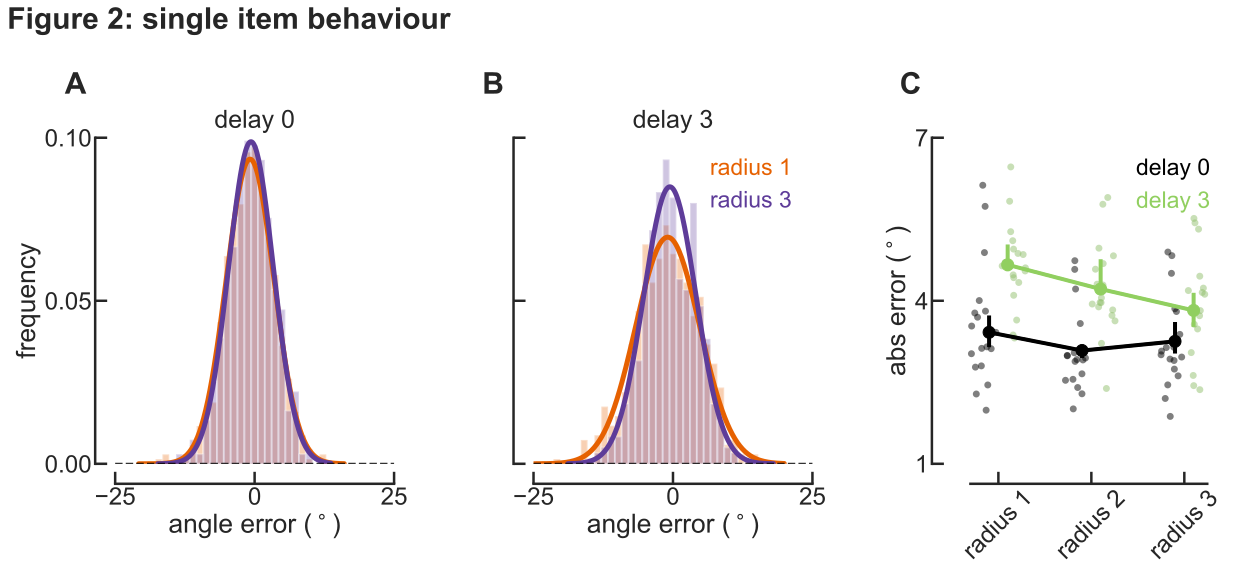

In [37]:
### Figure paper
f = plt.figure(figsize=(20,6))
ax = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)


f.text(0.05, 1.15, "Figure 2: single item behaviour ", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.09, 1.0, "A", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.38, 1.0, "B", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.67, 1.0, "C", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)


plt.subplot(131)

# read data from a text file. One number per line
datos_d0_r1 = df_cont.loc[ (df_cont['r_T']==7.72) & (df_cont['delay']==0)   , 'A_err']
mu_r1, sigma_r1 = norm.fit(datos_d0_r1)
datos_d0_r3 = df_cont.loc[ (df_cont['r_T']==13.68) & (df_cont['delay']==0)   , 'A_err']
mu_r3, sigma_r3 = norm.fit(datos_d0_r3)

sns.distplot(datos_d0_r1, color= c_r1, fit=norm, kde=False, fit_kws={"color":c_r1, 'linewidth':5},
             bins=np.linspace(-30,30,50), ax=ax, hist_kws={'alpha':0.3})
sns.distplot(datos_d0_r3, color=c_r3, fit=norm, kde=False, fit_kws={"color":c_r3, 'linewidth':5},
             bins=np.linspace(-30,30,50), ax=ax, hist_kws={'alpha':0.3})

#plot
plt.xlabel(r'angle error ($^\circ$)')
plt.ylabel('frequency')
#plt.title(r'$\mathrm{Delay=0:}\ \sigma_{r1}=%.3f,\ \sigma_{r3}=%.3f$' %(sigma_r1, sigma_r3))
plt.title('delay 0',  fontsize=25, pad=10)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
adjust_spines(plt.gca(), ['left', 'bottom'])



plt.yticks([0, 0.05,0.1])
plt.xticks([-25, 0, 25])
plt.legend(frameon=False)
plt.ylim(0,0.1)
plt.plot([-25,25], [0,0], 'k--', linewidth=2);
plt.xlim(-25,25)


plt.subplot(132)

# read data from a text file. One number per line
datos_d3_r1 = df_cont.loc[ (df_cont['r_T']==7.72) & (df_cont['delay']==3)   , 'A_err']
mu_r1, sigma_r1 = norm.fit(datos_d3_r1)
datos_d3_r3 = df_cont.loc[ (df_cont['r_T']==13.68) & (df_cont['delay']==3)   , 'A_err']
mu_r3, sigma_r3 = norm.fit(datos_d3_r3)

sns.distplot(datos_d3_r1, color= c_r1, fit=norm, kde=False, label='radius 1', fit_kws={"color":c_r1, 'linewidth':5},
             bins=np.linspace(-30,30,50), ax=ax2, hist_kws={'alpha':0.3})
sns.distplot(datos_d3_r3, color=c_r3, fit=norm, kde=False, label='radius 3', fit_kws={"color":c_r3, 'linewidth':5},
             bins=np.linspace(-30,30,50), ax=ax2, hist_kws={'alpha':0.3})

#plot
plt.xlabel(r'angle error ($^\circ$)')
plt.ylabel('')
#plt.title(r'$\mathrm{Delay=3:}\ \sigma_{r1}=%.3f,\ \sigma_{r3}=%.3f$' %(sigma_r1, sigma_r3))
plt.title('delay 3', fontsize=25, pad=10)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.yticks([0,0.05,0.1], ['', ''])
plt.xticks([-25, 0, 25])


plt.ylim(0,0.1)
plt.plot([-25,25], [0,0], 'k--', linewidth=2);
plt.xlim(-25,25)

adjust_spines(plt.gca(), ['left', 'bottom'])


l = plt.legend(loc=1, frameon=False, prop={'size': 23})
l.get_texts()[0].set_text('radius 1');
l.get_texts()[0].set_color(c_r1);
l.get_texts()[1].set_text('radius 3');
l.get_texts()[1].set_color(c_r3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);




plt.subplot(133)


linares_plot(x='r_T', y='abs_err', hue='delay', hue_order=[0,3], order=[7.72,10.7,13.68], df=df_cont,palette=[c_d0, c_d3], 
            alpha=0.5, point_size=7,  by_subj=True, subj_col='subject', plot_box='line', reps=1000)
plt.legend(frameon=False)
#plt.title('error in eccentricity', fontsize=25, pad=10)
plt.xlabel('')

plt.ylabel(r'abs error ($^\circ$)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')

adjust_spines(plt.gca(), ['left', 'bottom'])

#plt.ylim(2, 8)

l = plt.legend(loc=1, frameon=False, prop={'size': 23})
l.get_texts()[0].set_text('delay 0')
l.get_texts()[1].set_text('delay 3')
l.get_texts()[0].set_color(c_d0);
l.get_texts()[1].set_color(c_d3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);

plt.xticks([0,1,2], ['radius 1', 'radius 2', 'radius 3'], rotation=45)
plt.yticks([1,4,7])



plt.subplots_adjust(wspace=0.5)
plt.show()

TypeError: linares_plot() got an unexpected keyword argument 'reps'

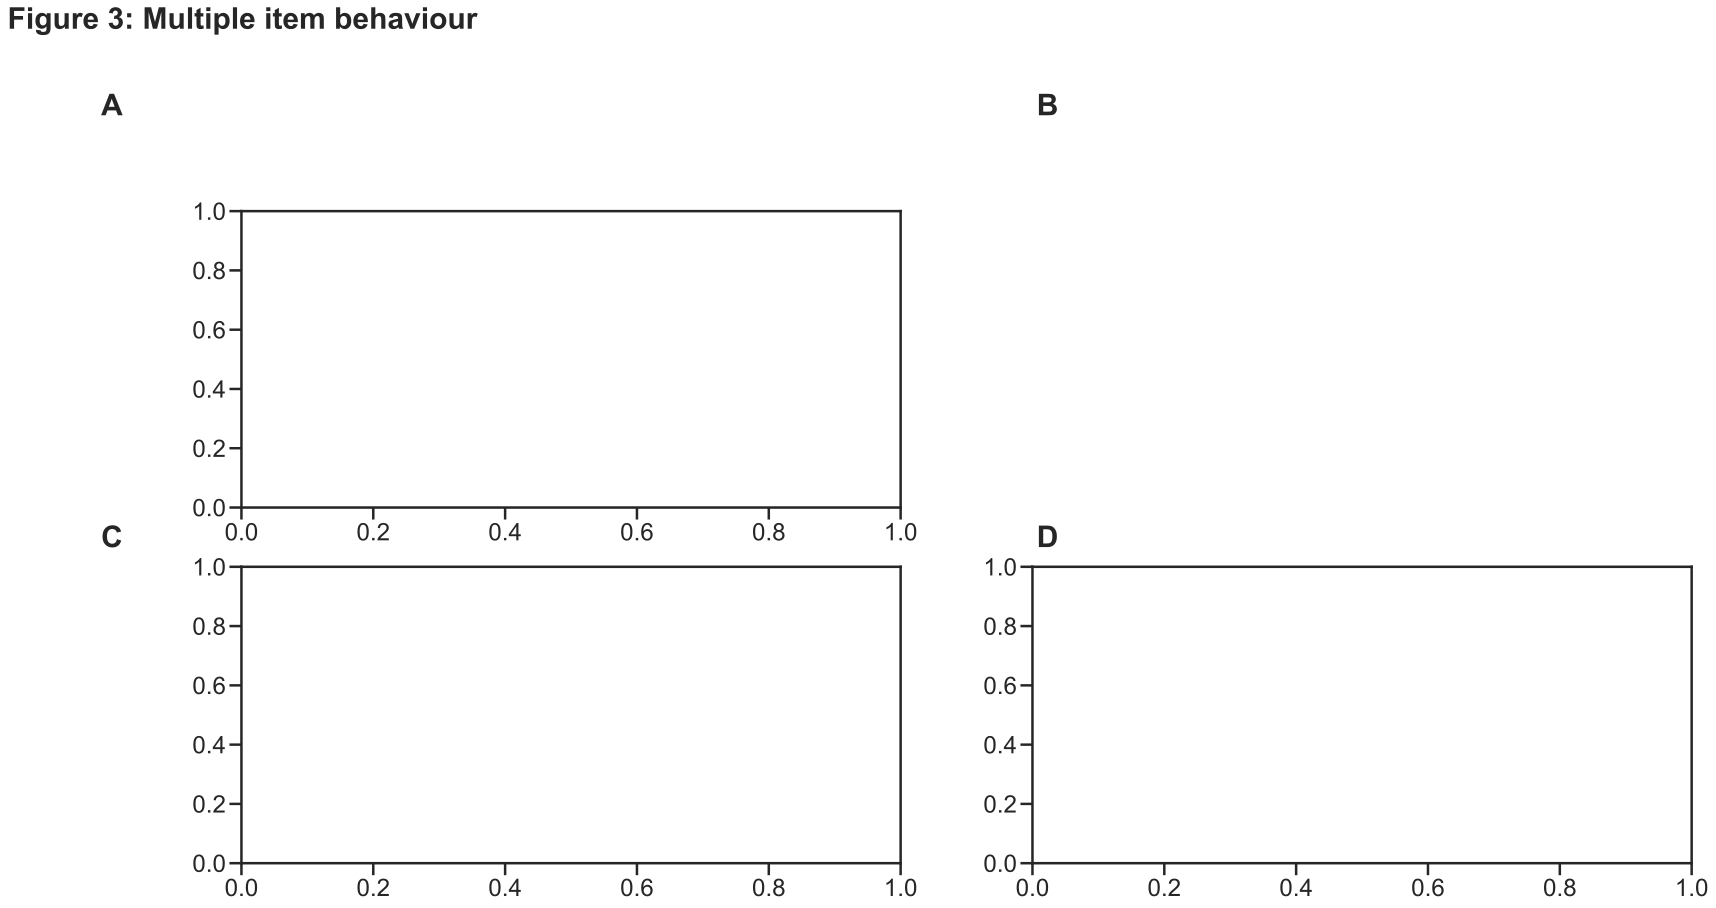

In [246]:
f = plt.figure(figsize=(26,12))
ax = f.add_subplot(223)
ax2 = f.add_subplot(224)


f.text(0, 1.1, "Figure 3: Multiple item behaviour ", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.05, 1.0, "A", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.55, 1.0, "B", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.05, 0.5, "C", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.55, 0.5, "D", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)




plt.subplot(221)


linares_plot(x='dist_T_NT', y='distance_A_err', hue='r_T', order=[12,16,20], hue_order=[7.72,13.68],
             alpha=0.4, palette=[c_r1, c_r3], df=df.loc[df['delay']==0], point_size=7,  by_subj=True, subj_col='subject',
            plot_box='line',  LW=5, MS=15, , reps=1000)


plt.legend(frameon=False)
plt.title('perceptual interference')
plt.plot([-0.3, 2.3], [0,0], 'k--', linewidth=2.5);
plt.xlabel(r'distance T - NT ($^\circ$)');
plt.xticks([0,1,2], ['12', '14', '16'])
plt.ylabel(r'bias towards NT ($^\circ$)');
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.ylim(-8,4)
plt.yticks([-8,-4,0,4])
plt.text(2.3, 2.7, 'attraction', fontsize=17, rotation='vertical');
plt.text(2.3, -2.7, 'repulsion', fontsize=17, rotation='vertical');
l = plt.legend(loc=2, frameon=False, prop={'size': 20})
l.get_texts()[0].set_text('')
l.get_texts()[1].set_text('')
l.get_texts()[0].set_color(c_r1);
l.get_texts()[1].set_color(c_r3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);


plt.subplot(222)

linares_plot(x='dist_T_NT', y='dist_A_err_d3_d0', hue='r_T', order=[12,16,20], hue_order=[7.72,13.68], 
             alpha=0.4, palette=[c_r1, c_r3], df=df.loc[df['delay']==3], point_size=7,  
             by_subj=True, subj_col='subject',
              plot_box='line', LW=5, MS=15, reps=1000)
plt.legend(frameon=False)
plt.title('memory interference')
plt.plot([-0.3, 2.3], [0,0], 'k--', linewidth=2.5);
plt.xlabel(r'distance T - NT ($^\circ$)');
plt.xticks([0,1,2], ['12', '14', '16'])
plt.ylabel('');
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.ylim(-4,4)
plt.yticks([-4,-2,0,2,4])
plt.text(2.5, 2.7, 'attraction', fontsize=17, rotation='vertical');
plt.text(2.5, -0.7, 'repulsion', fontsize=17, rotation='vertical');
l = plt.legend(loc=1, frameon=False, prop={'size': 22})
l.get_texts()[0].set_text('radius 1')
l.get_texts()[1].set_text('radius 3')
l.get_texts()[0].set_color(c_r1);
l.get_texts()[1].set_color(c_r3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);




plt.subplot(223)
sns.distplot(df.loc[(df['delay']==0) & (df['dist_T_NT']==12) & (df['r_T']==7.72), 'distance_A_err'] , bins=np.linspace(-10,10,25), 
              fit=norm, kde=False, fit_kws={"color":c_r1, 'linewidth':2}, label='radius 1', color=c_r1, ax=ax)
sns.distplot(df.loc[(df['delay']==0) & (df['dist_T_NT']==12) & (df['r_T']==13.68), 'distance_A_err'] , bins=np.linspace(-10,10,25),
             fit=norm, kde=False, fit_kws={"color":c_r3, 'linewidth':2}, label='radius 3',  color=c_r3,ax=ax)
plt.plot([0, 0], [0,0.17], 'k--', linewidth=2.5, label='target');
plt.xlim(-20,20)
plt.plot([-20,20], [0,0], 'k--', linewidth=2);
plt.xticks([-20, -10, 0, 10, 20])
plt.ylim(-0.01, 0.02)
plt.yticks([0, 0.1,0.2])
#plt.plot([12, 12], [0,0.17], color='grey', linestyle='-', linewidth=2.5, label='NT');
#plt.plot((12,10), "^", color='grey', markersize=10, label='NT=12');

#l = plt.legend(loc='best', frameon=False, prop={'size': 16})
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.xlabel(r'distance to target ($^\circ$)')
plt.ylabel('frequency')
plt.text(5.2, 0.06, 'attraction', fontsize=22);
plt.text(-16, 0.06, 'repulsion', fontsize=22);
#plt.title(r'12$\circ$: Delay0')
#plt.title('perceptual distribution')
plt.annotate('', xy=(-16, 0.05),  xytext=(-9, 0.05),  arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='bottom');

plt.annotate('', xy=(12, 0.05), xytext=(5, 0.05), arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='bottom');


#pts = [(11, 0), (12, 0.01), (13, 0)]
pts = [(11, -0.010), (12, -0.001), (13, -0.010)]
triangle = plt.Polygon(pts, color='grey', fill=True, edgecolor='grey')
ax.add_patch(triangle)
plt.text(11.7, 0.005, 'NT', fontsize=15);

adjust_spines(plt.gca(), ['left', 'bottom'])


plt.subplot(224)
sns.distplot(df.loc[(df['delay']==3) & (df['dist_T_NT']==12) & (df['r_T']==7.72), 'dist_A_err_d3_d0'] , bins=np.linspace(-10,10,25),
              fit=norm, kde=False, fit_kws={"color":c_r1, 'linewidth':2}, label='radius 1', color=c_r1, ax=ax2)
sns.distplot(df.loc[(df['delay']==3) & (df['dist_T_NT']==12) & (df['r_T']==13.68), 'dist_A_err_d3_d0'] , bins=np.linspace(-10,10,25),
             fit=norm, kde=False, fit_kws={"color":c_r3, 'linewidth':2}, label='radius 3',  color=c_r3, ax=ax2)
plt.plot([0, 0], [0,0.17], 'k--', linewidth=2.5, label='target');
plt.xlim(-20,20)
plt.xticks([-20, -10, 0, 10, 20])
plt.ylim(-0.01, 0.02)
plt.plot([-20,20], [0,0], 'k--', linewidth=2);

##triangulo locura
#plt.plot((12,10), "^", color='grey', markersize=10, label='NT=12');



l = plt.legend(loc='best', frameon=False, prop={'size': 16})
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.xlabel(r'distance to target ($^\circ$)')
plt.ylabel('')
#plt.text(5.2, 0.06, 'attraction', fontsize=22);
#plt.text(-16, 0.06, 'repulsion', fontsize=22);
#plt.title(r'12$\circ$: Delay3 - Delay0')
plt.yticks([0,0.1,0.2], ['', '',  ''])

#plt.title('memory distribution')
# plt.annotate('', xy=(-16, 0.05),  xytext=(-9, 0.05),  arrowprops=dict(facecolor='black', shrink=0.05),
#             horizontalalignment='left', verticalalignment='bottom');

# plt.annotate('', xy=(12, 0.05), xytext=(5, 0.05), arrowprops=dict(facecolor='black', shrink=0.05),
#            horizontalalignment='left', verticalalignment='bottom');




pts = [(11, -0.010), (12, -0.001), (13, -0.010)]
triangle = plt.Polygon(pts, color='grey', fill=True, edgecolor='grey')
ax2.add_patch(triangle)
plt.text(11.7, 0.005, 'NT', fontsize=15);



adjust_spines(plt.gca(), ['left', 'bottom'])

plt.tight_layout()


plt.subplots_adjust(wspace=0.3, hspace=0.6)

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  wa

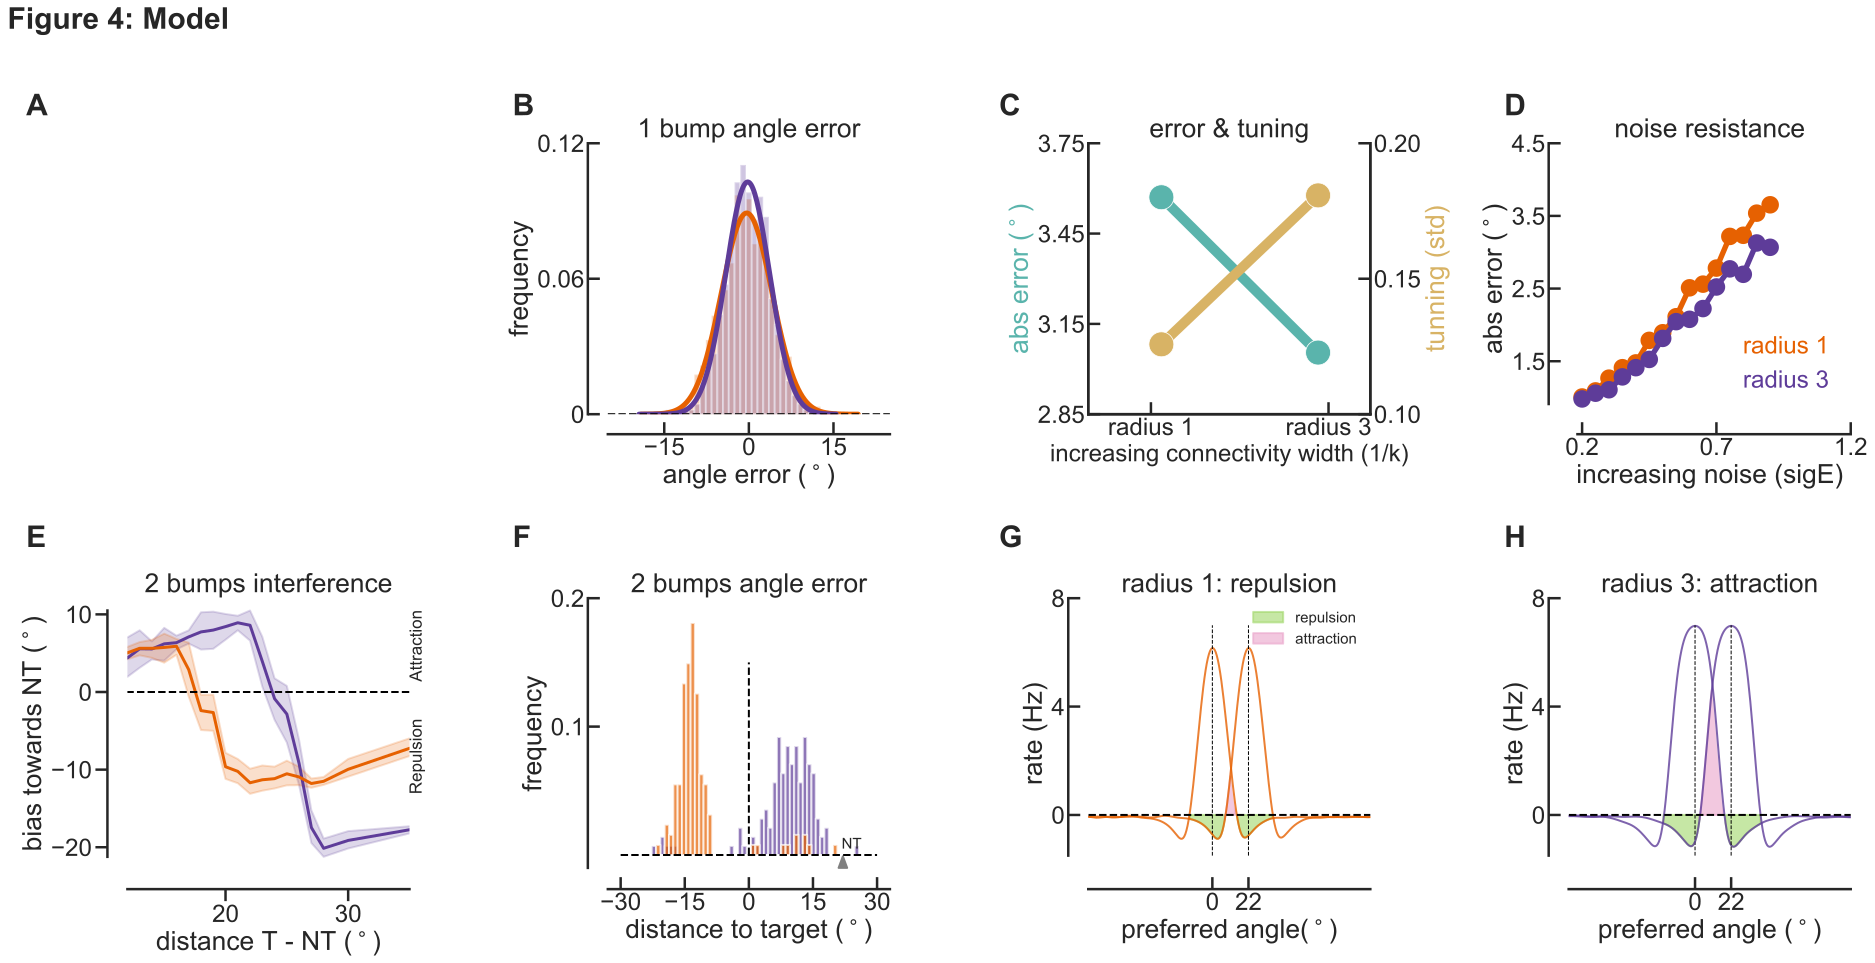

In [23]:
f = plt.figure(figsize=(26,12))

axinv=  f.add_subplot(241)
ax1 = f.add_subplot(242)
ax2 = f.add_subplot(243)
ax3 = f.add_subplot(244)
ax4 = f.add_subplot(245)
ax5 = f.add_subplot(246)

f.text(0, 1.1, "Figure 4: Model ", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.01, 1.0, "A", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)


### 2nd plot
f.text(0.53, 1.0, "C", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)


c_tuning= '#d8b365' #'#e9a3c9'
c_error = '#5ab4ac' #'#a1d76a'
sns.lineplot( x="kappas_E", y="abs_bias", ci=None, data=df_1, markers=True,  
                 linewidth=10, marker="o", markersize=25, color=c_error, ax=ax2) 
ax2.set_ylim(2.85, 3.75)
ax2.set_yticks([2.85, 3.15, 3.45, 3.75])
ax2.set_ylabel(r'abs error ($^\circ$)')
ax2.spines['top'].set_visible(False)
ax2.tick_params(direction='in')
plt.xlabel('')
ax2.set_xlim(200, 335)
ax2.set_xticks([305, 220])
ax2.set_xticklabels(['radius 1','radius 3'])
ax2.invert_xaxis()
ax2.set_xlabel('increasing connectivity width (1/k)', fontsize=24)
ax2.yaxis.label.set_color(c_error)
ax12 = ax2.twinx()
sns.lineplot( x="kappas_E", y="gaussian_std", ci=None, data=df_fg, markers=True,  
                 linewidth=10, marker="o", markersize=25, color=c_tuning, ax=ax12) 

ax12.set_ylim(0.1, 0.2)
ax12.spines['top'].set_visible(False)
ax12.set_yticks([0.1, 0.15, 0.2])
ax12.set_ylabel('tunning (std)')
ax12.tick_params(direction='in')
ax12.set_xlabel('increasing connectivity width (1/k)', fontsize=24)
ax12.set_xticks([305, 220])
ax12.set_xticklabels(['radius 1','radius 3'])
ax12.yaxis.label.set_color(c_tuning)
plt.title('error & tuning')


#### 1st plot
f.text(0.27, 1.0, "B", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)

plt.subplot(242)
sns.distplot(df_1.loc[df_1['kappas_E']==300, 'b2'], color=c_r1,  bins=np.linspace(-30,30,60),
             label='radius 1', kde=False, fit=norm,  fit_kws={"color":c_r1, 'linewidth':5},
            hist_kws={'alpha':0.3}, ax=ax1)

sns.distplot(df_1.loc[df_1['kappas_E']==225, 'b2'], color=c_r3,  bins=np.linspace(-30,30,60),
             label='radius 3', kde=False, fit=norm,  fit_kws={"color":c_r3, 'linewidth':5},
            hist_kws={'alpha':0.3}, ax=ax1)

plt.xlabel(r'angle error ($^\circ$)')
plt.ylabel('')
plt.title('1 bump angle error')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.yticks([0, 0.06,  0.12], [0, 0.06, 0.12])
plt.xticks([-15, 0, 15])
plt.ylim(0,0.12)
plt.xlim(-25,25)
plt.plot([-25,25], [0,0], 'k--', linewidth=2);
plt.ylabel('frequency')
# l = plt.legend(loc=1, frameon=False, prop={'size': 18})
# l.get_texts()[0].set_text('radius 1: k=300');
# l.get_texts()[0].set_color(c_r1);
# l.get_texts()[1].set_text('radius 3: k=225');
# l.get_texts()[1].set_color(c_r3);
# l.legendHandles[0].set_visible(False);
# l.legendHandles[1].set_visible(False);
adjust_spines(plt.gca(), ['left', 'bottom'])




### 3th plot
f.text(0.8, 1.0, "D", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)


c_tuning= '#e9a3c9'
g =sns.factorplot( x="sigE", y="absb2", hue='kappa_E', data=df___, palette=[c_r1, c_r3], hue_order=[300,225],
                  ci=None, size=5, aspect=1.5, legend=False, ax=ax3);
plt.setp(g.ax.lines, linewidth=7)
plt.close()
ax3.set_ylabel(r'abs error ($^\circ$)')
ax3.set_xlabel('increasing noise (sigE)')
ax3.set_title('noise resistance')
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.get_xaxis().tick_bottom()
ax3.get_yaxis().tick_left()
ax3.tick_params(direction='in')
ax3.set_xlim(-1, 20)
ax3.set_xticks([0,10,20])
ax3.set_xticklabels( [0.2, 0.7, 1.2])
l=ax3.legend(frameon=False, loc=4)
l.get_texts()[0].set_text('radius 1');
l.get_texts()[0].set_color(c_r1);
l.get_texts()[1].set_text('radius 3');
l.get_texts()[1].set_color(c_r3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);
adjust_spines(ax3, ['left', 'bottom'])
ax3.set_yticks([ 1.5, 2.5, 3.5, 4.5]);




##4th plot
f.text(0.01, 0.5, "E", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)


g = sns.lineplot( x="separation", y="bias", hue='kappas_E', ci=95 , palette=[c_r3, c_r1], data=df_model, legend=False, ax=ax4) 
ax4.plot([0, max(df_model['separation'])], [0,0], 'k--', linewidth=2) 
#plt.title('model: memory bias', fontsize=25) #condition title
ax4.spines['right'].set_visible(False) #no right axis
ax4.spines['top'].set_visible(False) #no  top axis
ax4.get_xaxis().tick_bottom()
ax4.get_yaxis().tick_left()
# l = ax4.legend(loc=3, frameon=False, prop={'size': 16})
# l.get_texts()[0].set_text('');
# l.get_texts()[1].set_text('radius 1: k=300');
# l.get_texts()[1].set_color(c_r1);
# l.get_texts()[2].set_text('radius 3: k=225');
# l.get_texts()[2].set_color(c_r3);
# l.legendHandles[1].set_visible(False);
# l.legendHandles[2].set_visible(False);
ax4.set_xlim(12, 35)
ax4.text(35, 9, 'Attraction', fontsize=17, rotation='vertical');
ax4.text(35, -5, 'Repulsion', fontsize=17, rotation='vertical');
ax4.set_xlabel(r'distance T - NT ($^\circ$)');
ax4.set_ylabel(r'bias towards NT ($^\circ$)');
adjust_spines(ax4, ['left', 'bottom'])
ax4.set_title('2 bumps interference')





### 5th plot
f.text(0.27, 0.5, "F", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)

plt.subplot(246)
sns.distplot(values_225, color=c_r3, bins=np.linspace(-50,50,100), kde=False, fit=norm, 
              label='radius 3', hist_kws={"alpha":0.7}, fit_kws={"color":c_r3, 'linewidth':0}, ax=ax5)
sns.distplot(values_300,  color=c_r1, bins=np.linspace(-50,50,100), kde=False, fit=norm, 
             label='radius 1', hist_kws={"alpha":0.7}, fit_kws={"color":c_r1, 'linewidth':0}, ax=ax5)


ax5.plot([-30, 30], [0,0], 'k--', linewidth=2) 
ax5.plot([0,0], [0,0.15], 'k--', linewidth=2, label='target') 
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')
plt.xlabel(r'distance to target ($^\circ$)')
plt.ylabel('frequency')
plt.yticks([0.1,0.2, 0.3])
plt.xticks([-30, -15, 0, 15, 30])
plt.xlim(-33, 33)
plt.ylim(-0.011,0.2)
# l = plt.legend(loc=1, frameon=False, prop={'size': 16})
# l.get_texts()[0].set_text('target');
# l.get_texts()[1].set_text('radius 1: k=300');
# l.get_texts()[1].set_color(c_r1);
# l.get_texts()[2].set_text('radius 3: k=225');
# l.get_texts()[2].set_color(c_r3);
# l.legendHandles[1].set_color(c_r1);
# l.legendHandles[2].set_color(c_r3);
adjust_spines(plt.gca(), ['left', 'bottom'])
pts = [(21, -0.01), (22, -0.001), (23, -0.01)]
triangle = plt.Polygon(pts, color='grey', fill=True, edgecolor='grey')
ax5.add_patch(triangle)
plt.text(21.7, 0.005, 'NT', fontsize=15);
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.title('2 bumps angle error')



### 6th plot
f.text(0.53, 0.5, "G", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)

plt.subplot(247)
static = current_300
displaced= np.roll(current_300, int(sep_neurons))
x=np.linspace(0,N-1,N)
plt.plot(static, color=c_r1, linewidth=2, alpha=0.8)
plt.plot([np.where(static == max(static))[0][0], np.where(static == max(static))[0][0]],[-1.5,7], 'k--', linewidth=1)
plt.plot(displaced, color=c_r1, linewidth=2, alpha=0.8 )
plt.plot([0,512], [0,0], 'k--', linewidth=2)
plt.plot([np.where(displaced == max(displaced))[0][0], np.where(displaced == max(displaced))[0][0]],[-1.5,7], 'k--', linewidth=1)
plt.xlim(150,400)
plt.title('radius 1: repulsion')
stat_disp = np.argwhere(np.diff(np.sign(displaced - static))).flatten()[13:16]
ref_static = np.argwhere(np.diff(np.sign(ref - static))).flatten()
ref_displaced = np.argwhere(np.diff(np.sign(ref - displaced))).flatten()
ref=np.zeros(512)
plt.fill_between(x,ref, displaced, where=((np.array(x>stat_disp[0]) *np.array(x<stat_disp[1]) * np.array(displaced<0))), color=rep_color, alpha=0.6)
plt.fill_between(x,ref, static, where=((np.array(x>stat_disp[1]) *np.array(x<stat_disp[2]) * np.array(static<0))), color=rep_color, alpha=0.6, label='repulsion')
plt.fill_between(x,displaced, ref, color=att_color, where=((np.array(x>=ref_displaced[0]) * np.array(x<ref_static[1]))), alpha=0.6, label='attraction')
plt.fill_between(x,displaced, static, color="white", where=((np.array(x>=stat_disp[1]) * np.array(x<=ref_static[1]))), alpha=1)
plt.legend(loc=1, frameon=False, prop={'size': 15} )
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in')
plt.ylim(-2, 8)
plt.yticks([0, 4, 8])
plt.xticks([np.where(static==max(static))[0][0], np.where(displaced==max(displaced))[0][0]], [0, 22])
plt.xlim(150,400)
plt.xlabel(r'preferred angle($^\circ$)')
plt.ylabel(r'rate (Hz)')
adjust_spines(plt.gca(), ['left', 'bottom'])


### 7th plot
f.text(0.8, 0.5, "H", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)

plt.subplot(248)
static = current_225
displaced= np.roll(current_225, int(sep_neurons))
x=np.linspace(0,N-1,N)
plt.plot(static, color=c_r3, linewidth=2, alpha=0.8)
plt.plot([np.where(static == max(static))[0][0], np.where(static == max(static))[0][0]],[-1.5,7], 'k--', linewidth=1)
plt.plot(displaced, color=c_r3, linewidth=2, alpha=0.8 )
plt.plot([0,512], [0,0], 'k--', linewidth=2)
plt.plot([np.where(displaced == max(displaced))[0][0], np.where(displaced == max(displaced))[0][0]],[-1.5,7], 'k--', linewidth=1)
plt.xlim(150,400)
plt.title('radius 3: attraction')
stat_disp = np.argwhere(np.diff(np.sign(displaced - static))).flatten()[5:8]
ref_static = np.argwhere(np.diff(np.sign(ref - static))).flatten()
ref_displaced = np.argwhere(np.diff(np.sign(ref - displaced))).flatten()
ref=np.zeros(512)
plt.fill_between(x,ref, displaced, where=((np.array(x>stat_disp[0]) *np.array(x<stat_disp[1]) * np.array(displaced<0))), color=rep_color, alpha=0.6)
plt.fill_between(x,ref, static, where=((np.array(x>stat_disp[1]) *np.array(x<stat_disp[2]) * np.array(static<0))), color=rep_color, alpha=0.6, label='repulsion')
plt.fill_between(x,displaced, ref, color=att_color, where=((np.array(x>=ref_displaced[0]) * np.array(x<ref_static[1]))), alpha=0.6, label='attraction')
plt.fill_between(x,displaced, static, color="white", where=((np.array(x>=stat_disp[1]) * np.array(x<=ref_static[1]))), alpha=1)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in')
plt.ylim(-2, 8)
plt.yticks([0, 4, 8])
plt.xticks([np.where(static==max(static))[0][0], np.where(displaced==max(displaced))[0][0]], [0, 22])
plt.xlim(150,400)
plt.xlabel(r'preferred angle ($^\circ$)')
plt.ylabel(r'rate (Hz)')
adjust_spines(plt.gca(), ['left', 'bottom'])

f.delaxes(axinv)

plt.tight_layout(h_pad=8, w_pad=3)

plt.show()

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  wa

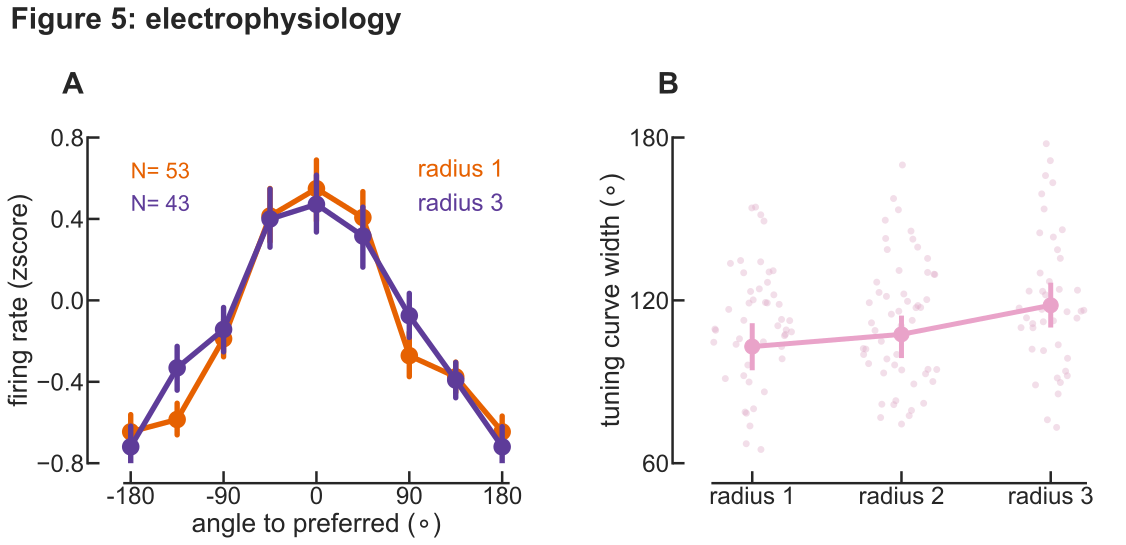

In [236]:
f = plt.figure(figsize=(18,6))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

f.text(0.05, 1.15, "Figure 5: electrophysiology ", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.09, 1.0, "A", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.55, 1.0, "B", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)

plt.subplot(121);

sns.factorplot( x="angle", y="firing", data=df_firings, hue='radius', 
               palette=[c_r1, c_r3], ci=68, size=6, aspect=1.5, legend=False, ax=ax);
plt.close()
ax.set_xlabel(r'angle to preferred ($\circ$)');
ax.set_ylabel('firing rate (zscore)')
#ax.set_title('tuning curves')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.tick_params(direction='in')
ax.set_xticks([ 0, 2, 4, 6, 8])

n_r1 = len(df_firings.loc[(df_firings['radius']==' radius 1') & (df_firings['angle']==0) ])
n_r3 = len(df_firings.loc[(df_firings['radius']=='radius 2') & (df_firings['angle']==0) ])
plt.text(0, 0.6, 'N= ' + str(n_r1), fontsize=22, color=c_r1);
plt.text(0, 0.44, 'N= ' + str(n_r3), fontsize=22, color=c_r3);

ax.set_xticklabels([-180, -90, 0, 90, 180]);

l= ax.legend(loc=1, frameon=False)
l.get_texts()[0].set_text('radius 1');
l.get_texts()[0].set_color(c_r1);
l.get_texts()[1].set_text('radius 3');
l.get_texts()[1].set_color(c_r3);
l.legendHandles[0].set_visible(False);
l.legendHandles[1].set_visible(False);

ax.set_ylim(-0.8, 0.8);
ax.set_yticks([ -0.8, -0.4, 0, 0.4, 0.8]);
adjust_spines(ax, ['left', 'bottom'])



plt.subplot(122);
# g = sns.factorplot( x="radius", y="tuning_std", data=df_m, palette=c_tuning, ci=68, size=5, aspect=1.5, ax=ax2);
df_m['tuning_std_deg'] = df_m['tuning_std']*180/np.pi

linares_plot(x='radius', y='tuning_std_deg', order=[1,2,3], 
             alpha=0.4, palette=[c_tuning], df=df_m, point_size=7, plot_box='line', LW=5, MS=15, reps=1000)
#plt.close()
ax2.set_xlabel(r'')
ax2.set_ylabel(r'tuning curve width ($\circ$)')
#ax2.set_title('tuning curve width ($\circ$)')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.get_xaxis().tick_bottom()
ax2.get_yaxis().tick_left()
ax2.tick_params(direction='in')
ax2.set_ylim( 60,180)
ax2.set_yticks([60,120, 180]);
ax2.set_xlim(-0.4, 2.4);
ax2.set_xticks([0,1,2])
ax2.set_xticklabels(['radius 1', 'radius 2', 'radius 3'])
adjust_spines(ax2, ['left', 'bottom'])



plt.subplots_adjust(wspace=0.4)



